# Imports and data read

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel("alldata.xlsx")

## 1. Age of the candidates per party
For this section, analysis will be performed by simply using the `groupby` on the `'parti'` and calling `mean`.

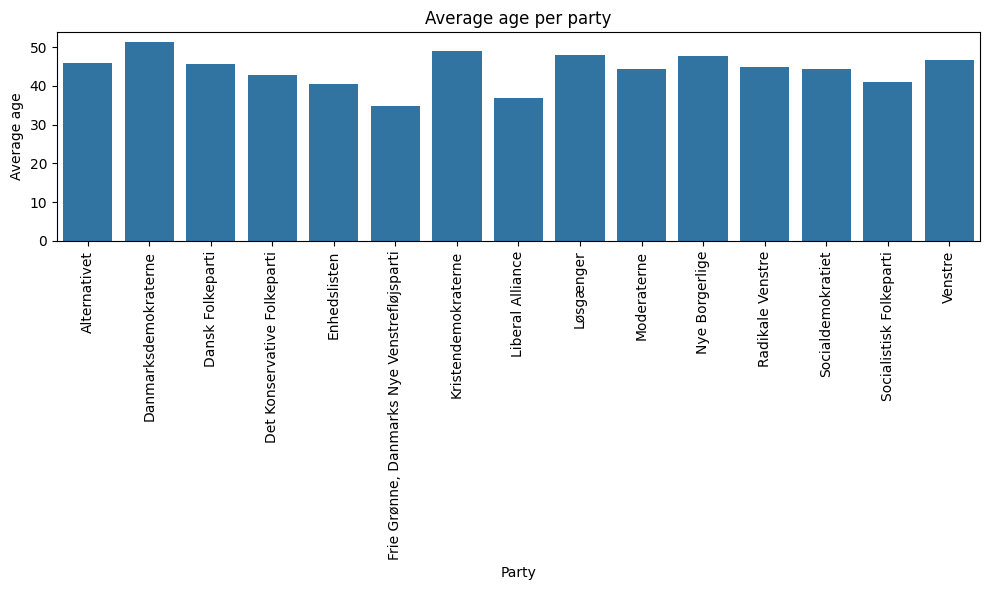

,parti,alder
0,Alternativet,46.00
1,Danmarksdemokraterne,51.22
2,Dansk Folkeparti,45.53
3,Det Konservative Folkeparti,42.90
4,Enhedslisten,40.51
5,"Frie Grønne, Danmarks Nye Venstrefløjsparti",34.81
6,Kristendemokraterne,49.02
7,Liberal Alliance,36.89
8,Løsgænger,48.00
9,Moderaterne,44.26


In [193]:
grouped_data = data.groupby('parti')['alder'].mean().round(2).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='parti', y='alder', data=grouped_data)
plt.title('Average age per party')
plt.xlabel('Party')
plt.ylabel('Average age')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

display(grouped_data)

## 2. Overview of the most confident candidates

In [194]:
candidates = data.copy()
q_cols = candidates.filter(regex='^[0-9]').columns

candidates[q_cols] = candidates[q_cols].apply(lambda x: abs(x))
candidates['confidence_ratio'] = candidates[q_cols].apply(lambda row: (row == 2).sum()/len(q_cols)*100, axis=1)

candidates_sorted = candidates[['navn', 'parti', 'storkreds', 'alder', 'confidence_ratio']].sort_values(by='confidence_ratio', ascending=False)

print("5 most confident candidates:")
display(candidates_sorted.head(5).style.format({'confidence_ratio': '{:.2f}%'}))
print("5 least confident candidates:")
display(candidates_sorted.tail(5).style.format({'confidence_ratio': '{:.2f}%'}))

5 most confident candidates:


,navn,parti,storkreds,alder,confidence_ratio
505,Sarah Nørris,Enhedslisten,Sydjyllands Storkreds,43,100.00%
88,Søren Vanting,Det Konservative Folkeparti,Østjyllands Storkreds,50,100.00%
559,Kim Andkjær Doberck,Nye Borgerlige,Sydjyllands Storkreds,43,89.80%
152,Rashid Ali,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Københavns Storkreds,38,87.76%
44,Mohamed Abdikarim,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Østjyllands Storkreds,33,87.76%


5 least confident candidates:


,navn,parti,storkreds,alder,confidence_ratio
226,Halima El Abassi,Socialdemokratiet,Københavns Storkreds,44,4.08%
509,Michael Mikkelsen,Danmarksdemokraterne,Sydjyllands Storkreds,50,0.00%
643,Søren Lund Hansen,Dansk Folkeparti,Sjællands Storkreds,48,0.00%
699,Kasper Roug,Socialdemokratiet,Sjællands Storkreds,43,0.00%
216,Lars Aslan Rasmussen,Socialdemokratiet,Københavns Storkreds,44,0.00%


## 3. Overview of global variance in responses and most conflicted parties

Global variance: 0.30553470870001553


C:\Users\iGor\AppData\Local\Temp\ipykernel_32540\1272631311.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intra_party_disagreement.index, y='mean_variance', data=intra_party_disagreement.reset_index(), palette='Blues')


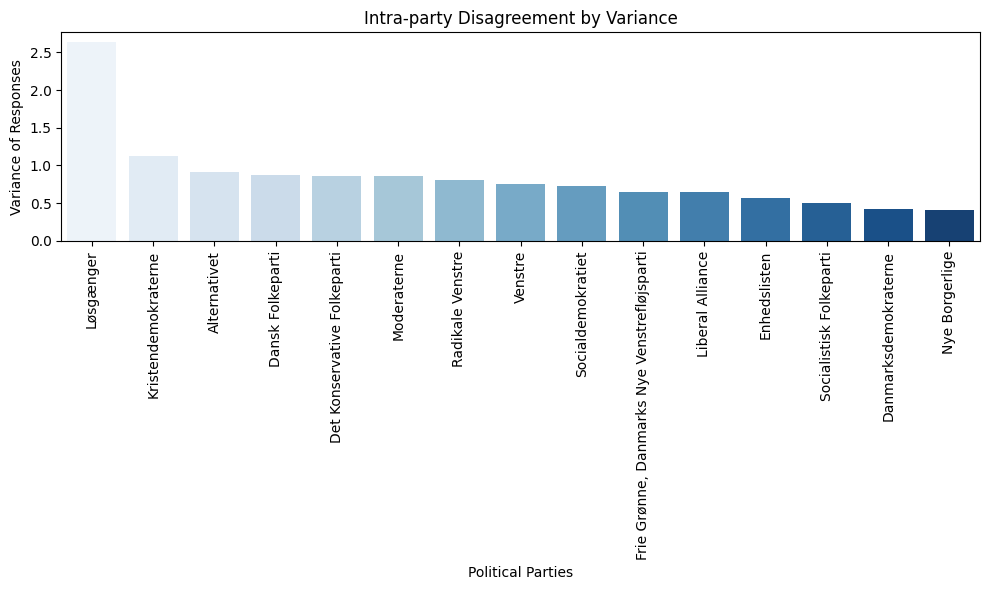

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_excel('alldata.xlsx')

response_columns = data.columns.difference(['navn', 'parti', 'storkreds', 'alder'])

#numeric_response_columns = data[response_columns].select_dtypes(include=['number']).columns
print(f"Global variance: {data[response_columns].var().var()}")
# Variance for each party
party_variances = data.groupby('parti')[response_columns].var()
party_variances['mean_variance'] = party_variances.mean(axis=1)
intra_party_disagreement = party_variances[['mean_variance']].sort_values(by='mean_variance', ascending=False)

# Party's mean
party_means = data.groupby('parti')[response_columns].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=intra_party_disagreement.index, y='mean_variance', data=intra_party_disagreement.reset_index(), palette='Blues')
plt.title('Intra-party Disagreement by Variance')
plt.xlabel('Political Parties')
plt.ylabel('Variance of Responses')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


The global variance was 0.3 - that is the number indicating a difference in the responses of all politicians compared to overall average.
Since the grading scale (responses) was the 5-grade scale (from -2 to 2), this suggests a relatively small spread, meaning that most politican answers are close to the average.

If the global variance was 0, that would mean that all 179 people in Folketinget gave the same answer for each question.
If the global variance was 4, it would mean that a;; responses were extreme (i.e. only strongly agree/disagree).

The party that has the most internal disagreement are Kristendemokraterne. However, the biggest variance was produced by people without the party. Their variance was ~2.6 meaning relatively wide spread of their answers. The average variance of all parties is low meaning parties tend to give similar answers. 

## -------MODEL SECTION-------

## 4. Decision tree

In [206]:
#Decision Tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_excel('alldata.xlsx')

response_columns = data.columns.difference(['navn', 'parti', 'storkreds', 'alder'])

X = data[response_columns]

#response to not being able to handle some of the data
y = data['parti'].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#DECISION TREE
clf = DecisionTreeClassifier(random_state=42, max_depth=8)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

#Storing misfits in the dataframe
comparison_df = pd.DataFrame({
    'Politician': data['navn'].iloc[X_test.index],  
    'Actual Party': y_test,
    'Predicted Party': y_pred
})
misclassified = comparison_df[comparison_df['Actual Party'] != comparison_df['Predicted Party']]

print(f"Model Accuracy: {accuracy:.2f}\n")
    
if not misclassified.empty:
    print("\nPoliticians who do not fit the model's prediction:\n")
    print(misclassified.to_string(index=False))
else:
    print("\nNo misclassified politicians.")

Model Accuracy: 0.72
Model Accuracy: 0.72


Politicians who do not fit the model's prediction:

                   Politician                                Actual Party                             Predicted Party
              Alex Ahrendtsen                            Dansk Folkeparti                           Socialdemokratiet
                  Morten Vehl                        Danmarksdemokraterne                                     Venstre
       Rasmus Helveg Petersen                            Radikale Venstre                                     Venstre
           Jan Allan Andersen                                Alternativet                            Radikale Venstre
                Jakob Schmidt                                Alternativet                     Socialistisk Folkeparti
                Sofie Lippert                     Socialistisk Folkeparti Frie Grønne, Danmarks Nye Venstrefløjsparti
               Michael Flarup                            Radikale Venstre     

## 5. Random forest classification

In [197]:
from sklearn.model_selection import train_test_split

features = data[list(q_cols) + ['navn']] # Reusing the questions-columns selection and adding name to be able to later recognize if the candidate was part of test or train set
labels = data['parti']

X_train_w_names, X_test_w_names, Y_train, Y_test = train_test_split(features, labels, test_size=0.5, shuffle=True)
X_train = X_train_w_names.drop('navn', axis='columns')
X_test = X_test_w_names.drop('navn', axis='columns')

In [198]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rforest = RandomForestClassifier(max_depth=6)

rforest.fit(X_train, Y_train)

Y_pred_forest = rforest.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred_forest)
#display("Accuracy: " + (correct_count/len(Y_test)))
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


In [199]:
candidate_assessment_forest = data[['navn', 'parti']].copy()
candidate_assessment_forest['forest_parti'] = rforest.predict(data[q_cols])
candidate_assessment_forest['train_set_member'] = candidate_assessment_forest['navn'].isin(X_train_w_names['navn'])

misfits_forest = candidate_assessment_forest[candidate_assessment_forest['parti'] != candidate_assessment_forest['forest_parti']]
misfits_f_share = len(misfits_forest)/len(data)
train_misfits_f_amount = len(misfits_forest[misfits_forest['train_set_member'] == True])

print(f"Amount of candidates, that should be in different parties according to the model: {len(misfits_forest)} ({misfits_f_share*100:.2f}%)")
print(f"out of which {train_misfits_f_amount} ({train_misfits_f_amount/len(misfits_forest)*100:.2f}%) are members of the train set.")
display(misfits_forest)

Amount of candidates, that should be in different parties according to the model: 55 (6.34%)
out of which 9 (16.36%) are members of the train set.


,navn,parti,forest_parti,train_set_member
2,Martin Kelleher-Petersen,Alternativet,Socialistisk Folkeparti,False
3,Nicklas Gjedsig Larsen,Alternativet,Socialdemokratiet,False
8,Chresten H. Ibsen,Løsgænger,Radikale Venstre,False
37,Gustav Juul,Venstre,Liberal Alliance,True
38,Michael Aastrup Jensen,Venstre,Danmarksdemokraterne,False
43,Sara Hvidbak Grouleff,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Alternativet,False
89,Per Urban Olsen,Det Konservative Folkeparti,Kristendemokraterne,False
92,Anders Krojgaard Lund,Det Konservative Folkeparti,Liberal Alliance,False
129,Emil Samaras,Enhedslisten,Socialistisk Folkeparti,False
140,Bo Sandroos,Venstre,Det Konservative Folkeparti,True


## 6. Gradient Boosting

In [200]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier(min_samples_split=20)

gboost.fit(X_train, Y_train)

Y_pred_gboost = gboost.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred_gboost)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.85


In [201]:
candidate_assessment_gboost = data[['navn', 'parti']].copy()
candidate_assessment_gboost['gboost_parti'] = gboost.predict(data[q_cols])
candidate_assessment_gboost['train_set_member'] = candidate_assessment_gboost['navn'].isin(X_train_w_names['navn'])

misfits_gboost = candidate_assessment_gboost[candidate_assessment_gboost['parti'] != candidate_assessment_gboost['gboost_parti']]
misfits_g_share = len(misfits_gboost)/len(data)
train_misfits_g_amount = len(misfits_gboost[misfits_gboost['train_set_member'] == True])

print(f"Amount of candidates, that should be in different parties according to the model: {len(misfits_gboost)} ({misfits_g_share*100:.2f}%)")
print(f"out of which {train_misfits_g_amount} ({train_misfits_g_amount/len(misfits_gboost)*100:.2f}%) are members of the train set.")
display(misfits_gboost)

Amount of candidates, that should be in different parties according to the model: 65 (7.50%)
out of which 0 (0.00%) are members of the train set.


,navn,parti,gboost_parti,train_set_member
1,Karsten Hønge,Socialistisk Folkeparti,Enhedslisten,False
3,Nicklas Gjedsig Larsen,Alternativet,Socialdemokratiet,False
6,Johan Kahl,Moderaterne,Løsgænger,False
8,Chresten H. Ibsen,Løsgænger,Alternativet,False
43,Sara Hvidbak Grouleff,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Alternativet,False
...,...,...,...,...
766,Egil Hulgaard,Det Konservative Folkeparti,Venstre,False
807,Aqeel Akhtar,"Frie Grønne, Danmarks Nye Venstrefløjsparti",Kristendemokraterne,False
823,Esben Frette Johnsen,Kristendemokraterne,Radikale Venstre,False
844,Henrik Sørensen,Det Konservative Folkeparti,Liberal Alliance,False


## 7. KNN

In [207]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_excel('alldata.xlsx')

response_columns = data.columns.difference(['navn', 'parti', 'storkreds', 'alder'])

X = data[response_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)  
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy: {accuracy:.2f}")

comparison_df = pd.DataFrame({
    'Politician': data['navn'].iloc[X_test.index],  
    'Actual Party': y_test,
    'Predicted Party': y_pred
})
misclassified = comparison_df[comparison_df['Actual Party'] != comparison_df['Predicted Party']]

if not misclassified.empty:
    print("\nPoliticians who do not fit the model's prediction:\n")
    print(misclassified.to_string(index=False))
else:
    print("\nNo misclassified politicians.")

KNN Model Accuracy: 0.94

Politicians who do not fit the model's prediction:

              Politician                                Actual Party             Predicted Party
           Jakob Schmidt                                Alternativet            Radikale Venstre
       Marianne Karlberg Frie Grønne, Danmarks Nye Venstrefløjsparti                Enhedslisten
               Araz Khan                                     Venstre Det Konservative Folkeparti
                Ole Gade                 Det Konservative Folkeparti            Liberal Alliance
  Kurt Vind Christiansen                            Liberal Alliance                     Venstre
     Christian Langballe                            Dansk Folkeparti              Nye Borgerlige
        Rasmus Hylleberg                                     Venstre            Liberal Alliance
              Selma Bolø                                Enhedslisten     Socialistisk Folkeparti
Marcus Techow Danielsson                         

## 8. Naive Bayes

In [208]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_excel('alldata.xlsx')

response_columns = data.columns.difference(['navn', 'parti', 'storkreds', 'alder'])

X = data[response_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

comparison_df = pd.DataFrame({
    'Politician': data['navn'].iloc[X_test.index],  
    'Actual Party': y_test,
    'Predicted Party': y_pred
})
misclassified = comparison_df[comparison_df['Actual Party'] != comparison_df['Predicted Party']]

if not misclassified.empty:
    print("\nPoliticians who do not fit the model's prediction:\n")
    print(misclassified.to_string(index=False))
else:
    print("\nNo misclassified politicians.")

Model Accuracy: 0.89

Politicians who do not fit the model's prediction:

               Politician                Actual Party                             Predicted Party
              Morten Vehl        Danmarksdemokraterne                            Dansk Folkeparti
            Sofie Lippert     Socialistisk Folkeparti Frie Grønne, Danmarks Nye Venstrefløjsparti
              Hira Nadeem            Liberal Alliance                 Det Konservative Folkeparti
     Lars Høyer Holmqvist            Liberal Alliance                 Det Konservative Folkeparti
         Dorte M. Nielsen     Socialistisk Folkeparti                                Enhedslisten
              Sinem Demir                Enhedslisten Frie Grønne, Danmarks Nye Venstrefløjsparti
            Marianne Mose                Enhedslisten Frie Grønne, Danmarks Nye Venstrefløjsparti
        John Hyrup Jensen     Socialistisk Folkeparti                                Alternativet
                 Ole Gade Det Konservative F